#  Прогнозирование заказов такси

Цель: Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.  Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План: 

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Импортируем необходимые библиотеки.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, TimeSeriesSplit, 
                                     train_test_split, cross_val_score)
from sklearn.tree import DecisionTreeRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv')

In [3]:
def analysis(df):
    print('Вывод первых 5 строк данных')
    print()
    display(df.head())
    print()
    print('Информация о датафрейме')
    print()
    display(df.info())
    print()
    print('Подсчет пропусков')
    print()
    print(df.isnull().sum())
    print()
    print('Подсчет дубликатов')
    print(df.duplicated().sum())

In [4]:
analysis(df)

Вывод первых 5 строк данных



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



Информация о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None


Подсчет пропусков

datetime      0
num_orders    0
dtype: int64

Подсчет дубликатов
0


Мы загрузили данные. В таблице 2 столбца и 26496 строк. Типы данных в столбцах — int64(1), object(1).
- Количество заказов находится в столбце 'num_orders' - целевой признак.
- Столбец datetime — значение даты и времени на временной оси. В этой таблице интервал равен 10 мин.

Пропусков и явных дубликатов нет. 

## Анализ

Нужно привести данные к удобному формату

In [5]:
# Изменим тип данных datetime с object на datetime64. 
df['datetime'] = df['datetime'].astype('datetime64')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


In [6]:
# Установим индекс таблицы равным столбцу datetime.
df.set_index('datetime', inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы is_monotonic (англ. «монотонный»). Если порядок соблюдён, атрибут вернёт True, если нет — False. Отсортируем индекс таблицы. 

In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


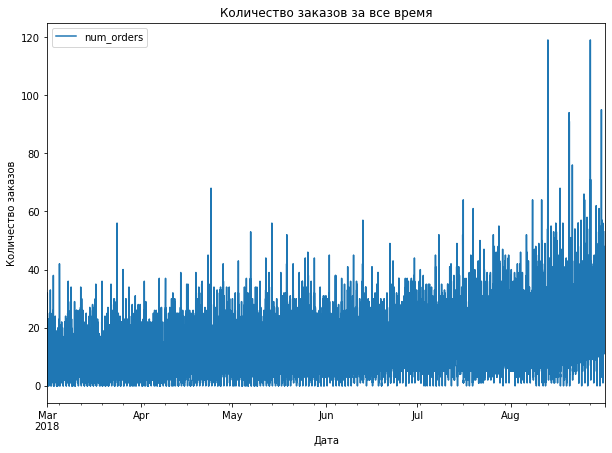

In [8]:
df.plot(figsize=(10, 7));
plt.legend()
plt.title('Количество заказов за все время')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show;

Итак, мы имеем данные с 01 марта 2018 года по 31 августа 2018 года. На графике есть несколько пиков, особенно заметно в августе.

Так как нам нужно спрогнозировать количество заказов такси на следующий час, то поменяем интервал временного ряда. Выполним его ресемплирование по одному часу.

In [9]:
df = df.resample('1H').sum()

In [10]:
print(f'Количество строк после ресемплинга :{df.shape}')

Количество строк после ресемплинга :(4416, 1)


Построим график временного ряда - количество заказов с марта по август 2018 года. Чтобы во временном ряду снизить колебания, применим скользящее среднее.

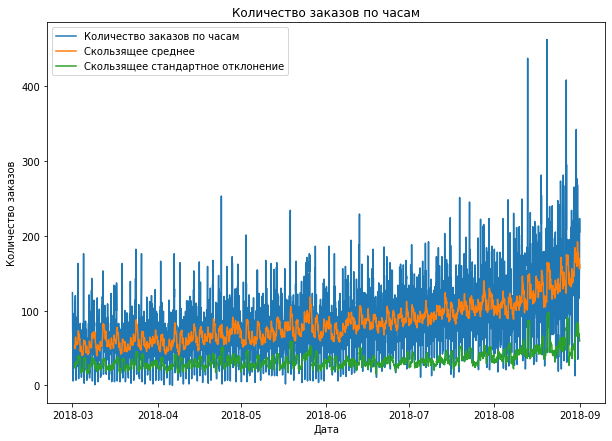

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(df, label = 'Количество заказов по часам')
plt.plot(df.rolling(20).mean(), label = 'Cкользящее среднее')
plt.plot(df.rolling(20).std(), label = 'Скользящее стандартное отклонение')
plt.legend()
plt.title('Количество заказов по часам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show;

На графике видно, что количество заказов увеличивается со временем. В период с марта по июнь 2018 ряд стационарный, а дальше ряд начинает изменяться.

Разложим временной ряд по трем составляющим: тренд, сезонность и остаток. Построим графики каждой составляющей.

In [12]:
decomposed = seasonal_decompose(df)

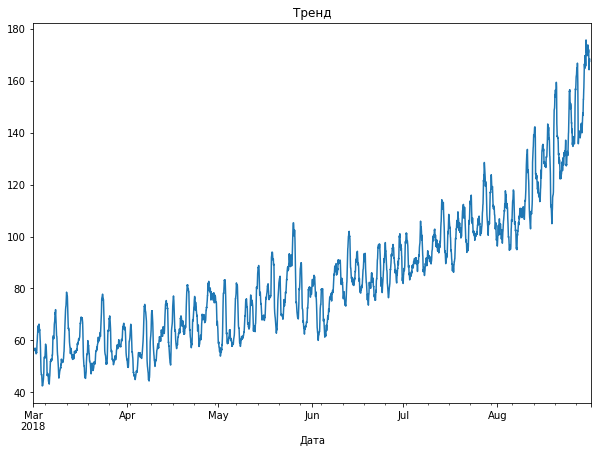

In [13]:
plt.figure(figsize=(10, 7))
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата');

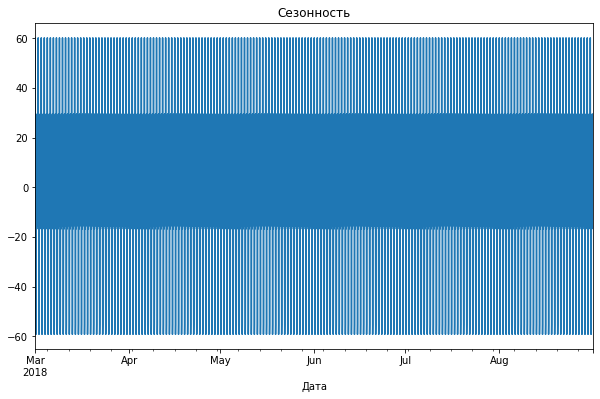

In [14]:
plt.figure(figsize=(10, 6))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата');

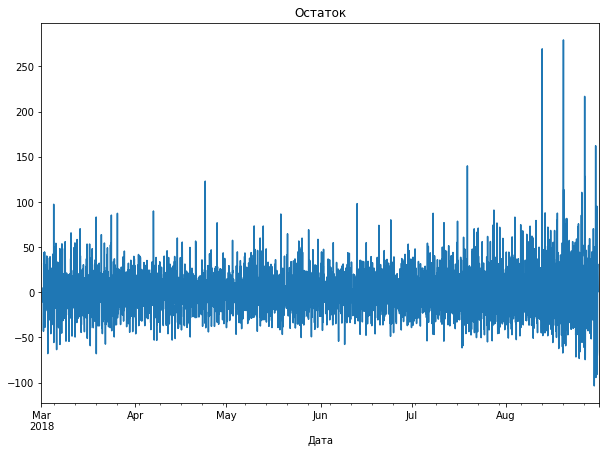

In [15]:
plt.figure(figsize=(10, 7))
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('Дата');

Посмотрим графики на коротких интервалах наблюдения.

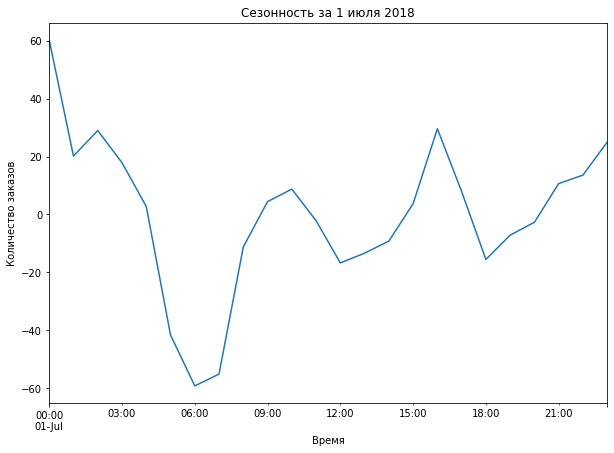

In [16]:
#Построим график количества заказов за сутки в июле. 
plt.figure(figsize=(10, 7))
decomposed.seasonal['2018-07-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Сезонность за 1 июля 2018')
plt.xlabel('Время');
plt.ylabel('Количество заказов')
plt.show;

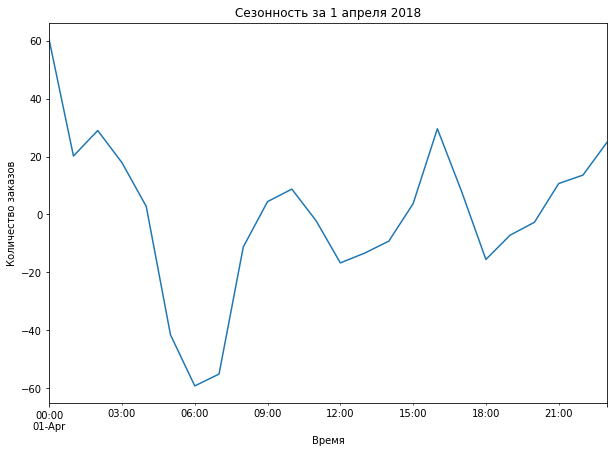

In [17]:
# Построим график количества заказов за сутки в июле. 
plt.figure(figsize=(10, 7))
decomposed.seasonal['2018-04-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Сезонность за 1 апреля 2018')
plt.xlabel('Время');
plt.ylabel('Количество заказов')
plt.show;

Графики за разные даты идентичны друг другу, то есть наблюдается сезонность. Высокий спрос на такси появляется ночью в 12 часов, так же достаточно много заказов с 15 до 16 часов и после 18 ч,  а низкий спрос в районе 4-7 утра.

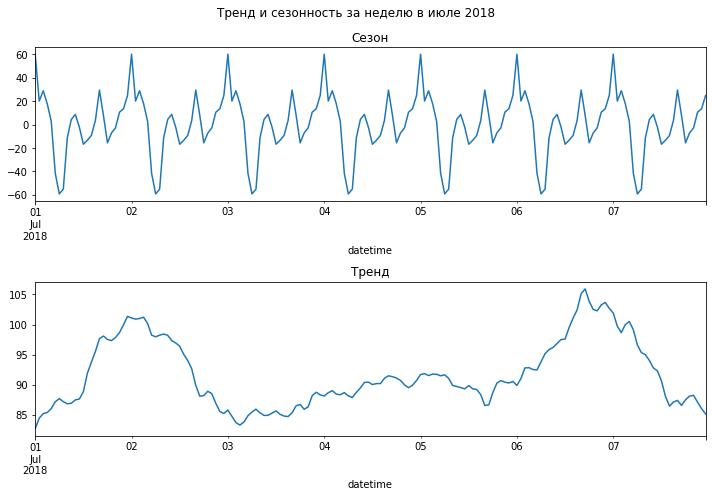

In [18]:
# Построим график количества заказов за неделю в июле. 

plt.figure(figsize=(10, 7))
plt.suptitle('Тренд и сезонность за неделю в июле 2018')

plt.subplot(2, 1, 1)
decomposed.seasonal['2018-07-01' : '2018-07-07'].plot(ax=plt.gca())
plt.title('Сезон')

plt.subplot(2, 1, 2)
decomposed.trend['2018-07-01' : '2018-07-07'].plot(ax=plt.gca())
plt.title('Тренд')

plt.tight_layout()
plt.show()

По графику видно наличие сезонности. Рост заказов наблюдается ближе к выходным и в понедельник. 

**Вывод:**
- Установили временной признак в качестве индекса.
- Мы проверили, что даты и время расположены в хронологическом порядке. Отсортировали индекс таблицы.
- Выполнили ресемплирование по одному часу.
- По графикам увидели, что количество заказов увеличивается от месяца к месяцу.
- Наблюдается сезонность в данных - количество заказов изменяется в зависимости от времени суток.
- Рост заказов проиходит ближе к выходным.
- Высокий спрос на такси появляется ночью в 12 часов, так же достаточно много заказов с 15 до 16 часов и после 18 ч,  а низкий спрос в районе 4-7 утра.

## Обучение

По исходным данным создадим обучающую (train) и тестовую (test) выборки. Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего

**Создание признаков**

Создадим признаки для горизонта прогнозирования в один шаг.
Напишем функцию для создания признаков. Разберём каждый тип признаков:
1. Календарные признаки (англ. calendar features)
Во многих данных тренды и сезонность привязаны к конкретной дате. 
2. «Отстающие значения» (англ. lag features)
Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. Получим отстающие значения знакомой функцией shift().
3. Скользящее среднее
Скользящее среднее как признак задаёт общий тренд временного ряда. 

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.dayofweek
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
# Вычислим отстающие значения. В функцию добавим новый аргумент max_lag, который задаст максимальный размер отставания. 
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)# 
# Вычислим скользящее среднее и добавим его как признак 'rolling_mean'.
# В функцию make_features() добавьте новый аргумент rolling_mean_size, который задаст ширину окна.
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 6)
print(df.head())

                     num_orders  hour  day  dayofweek  month  lag_1  lag_2  \
datetime                                                                     
2018-03-01 00:00:00         124     3    1          3      3    NaN    NaN   
2018-03-01 01:00:00          85     3    1          3      3  124.0    NaN   
2018-03-01 02:00:00          71     3    1          3      3   85.0  124.0   
2018-03-01 03:00:00          66     3    1          3      3   71.0   85.0   
2018-03-01 04:00:00          43     3    1          3      3   66.0   71.0   

                     lag_3  lag_4  lag_5  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00  124.0    NaN    NaN  ...   

In [20]:
# Проверим пропуски
df.isna().sum()

num_orders       0
hour             0
day              0
dayofweek        0
month            0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
rolling_mean     6
dtype: int64

In [21]:
# Удалим пропуски
df.dropna(inplace=True)
df.isna().sum()

num_orders      0
hour            0
day             0
dayofweek       0
month           0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   hour          4392 non-null   int64  
 2   day           4392 non-null   int64  
 3   dayofweek     4392 non-null   int64  
 4   month         4392 non-null   int64  
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17  lag_13        4392 non-null

In [23]:
df.head()

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,2,4,3,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.333333
2018-03-02 01:00:00,120,4,2,4,3,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,72.166667
2018-03-02 02:00:00,75,4,2,4,3,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,84.666667
2018-03-02 03:00:00,64,4,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,87.000000
2018-03-02 04:00:00,20,4,2,4,3,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,86.666667


In [24]:
# Разделим данные на обучающую и тестовую выборки
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']
# Проверим размер выборок
print(train.shape)
print(test.shape)

(3952, 30)
(440, 30)


**LinearRegression**

In [25]:
cv = TimeSeriesSplit(n_splits=3).split(train_features)
model_lr = LinearRegression() 
tscv = TimeSeriesSplit(n_splits=5)
model_lr.fit(train_features, train_target)
score_lr = cross_val_score(model_lr, train_features, train_target, scoring='neg_mean_squared_error', cv=tscv)
print('RMSE модели линейной регрессии::', round(np.mean(-score_lr)**0.5, 2))

RMSE модели линейной регрессии:: 27.23


**Ridge**

In [26]:
# Определение модели и гиперпараметров для подбора
model_ridge = Ridge(random_state=12345)
params = {'alpha': [0.1, 1, 10]}
tscv = TimeSeriesSplit(n_splits=5)
# Подбор гиперпараметров с использованием кросс-валидации
grid_search_ridge = GridSearchCV(model_ridge, param_grid=params, cv=tscv, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(train_features, train_target)
print('RMSE:', round(-grid_search_ridge.best_score_, 2))
print('Лучшие гиперпараметры модели:', grid_search_ridge.best_params_)

RMSE: 27.03
Лучшие гиперпараметры модели: {'alpha': 0.1}


**RandomForestRegressor**

In [ ]:
model_rfr = RandomForestRegressor(random_state=12345)

params =  {'max_depth': range (1,13, 2),'n_estimators': range (10, 31, 5)}
tscv = TimeSeriesSplit(n_splits=5)
grid_search_rfr = GridSearchCV(model_rfr, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs = -1)

grid_search_rfr.fit(train_features, train_target)

# получение наилучшей модели 
best_rfr = grid_search_rfr.best_estimator_

print('RMSE:', round(-grid_search_rfr.best_score_, 2))
print('Лучшие гиперпараметры модели:', grid_search_rfr.best_params_)

**DecisionTreeRegressor**

In [ ]:
model_dtr = DecisionTreeRegressor(random_state=12345)

params = {'max_depth': range(3, 20, 3)}
tscv = TimeSeriesSplit(n_splits=5)

grid_search_dtr = GridSearchCV(model_dtr, params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

grid_search_dtr.fit(train_features, train_target)

print('RMSE:', round(-grid_search_dtr.best_score_, 2))
print('Лучшие гиперпараметры модели:', grid_search_dtr.best_params_)

**Вывод:**

Создали новые признаки на основании календарных значений, скользащего среднего по количеству заказов и отстающих значений

Разбили данные на тренировочную и тестовую выборки.

Обучили следующие модели: LinearRegression, Ridge, RandomForestRegressor, DecisionTreeRegressor.

Модель RandomForestRegressor показала наилучший результат значения RMSE: 26.34
Лучшие гиперпараметры модели: {'max_depth': 11, 'n_estimators': 30}. 

## Тестирование

Модель RandomForestRegressor показала наилучший результат значения RMSE на тренировочных данных. Проверим как покажет себя модель RandomForestRegressor на тестовой выборке.

In [ ]:
pred_test_rfr = best_rfr.predict(test_features)
rmse_rfr = mean_squared_error(test_target, pred_test_rfr) ** 0.5
print('RMSE на тестовых данных:', round(rmse_rfr, 2))

Итак, RMSE на тестовой выборке = 44.02, этот результат хуже, чем на обучающей выборке, но требование заказчика, что значение метрики RMSE на тестовой выборке должно быть не больше 48 модель выполнила. 

Рассмотрим графики сравнения исходного и предсказанных рядов.

In [ ]:
pred_test_rfr = pd.DataFrame(pred_test_rfr, index=test_features.index)

plt.figure(figsize=(15,10))
plt.plot(test_target, label = "target")
plt.plot(pred_test_rfr, label = "predicted")
plt.title('Сравнение предсказаний')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.legend(['Исходные', 'Предсказанные'])
plt.show()

**Вывод**

Таким образом, мы изучили данные компании «Чётенькое такси» о заказах такси в аэропортах, чтобы привлечь больше водителей в период пиковой нагрузки.

В проекте была проделана следующая работа:

- Провели первичный анализ данных.
- Сформированы признаки для горизонта прогнозирования в один шаг, которые использовались в обучении моделей.
- Разбили данные на тренировочную и тестовую выборки.
- Обучили следующие модели: LinearRegression, Ridge, RandomForestRegressor, DecisionTreeRegressor.
- Модель RandomForestRegressor показала наилучший результат значения RMSE: RMSE: 24.9 Лучшие гиперпараметры модели: {'max_depth': 11, 'n_estimators': 30}.
- RMSE модели RandomForestRegressorн а тестовой выборке = 44.02, этот результат хуже, чем на обучающей выборке, но требование заказчика, что значение метрики RMSE на тестовой выборке должно быть не больше 48 модель выполнила. Таким образом, данная модель может в работе компании.